# Misinformation Detection
### Data Visualisation Notebook

*Session 20 Group 4*
*Erica, Sahan, Dinuka*


Imports:

In [1]:
import pandas as pd
import os
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns
from scipy.sparse import coo_matrix
from sklearn.preprocessing import LabelEncoder
import umap
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

Reading in data:

In [2]:
dataset = pd.read_csv("data/processed_dataset.csv", index_col=0)

dataset.head()

,text,label
0,the reason why jade helm is obama favorite con...,fake
1,us president donald trump revised hardline pol...,real
2,brazilian congressional report recommended on ...,real
3,ah the simpsons the hilarious animated show th...,fake
4,says former fbi director james comey admitted ...,fake


Visualise with a wordcloud

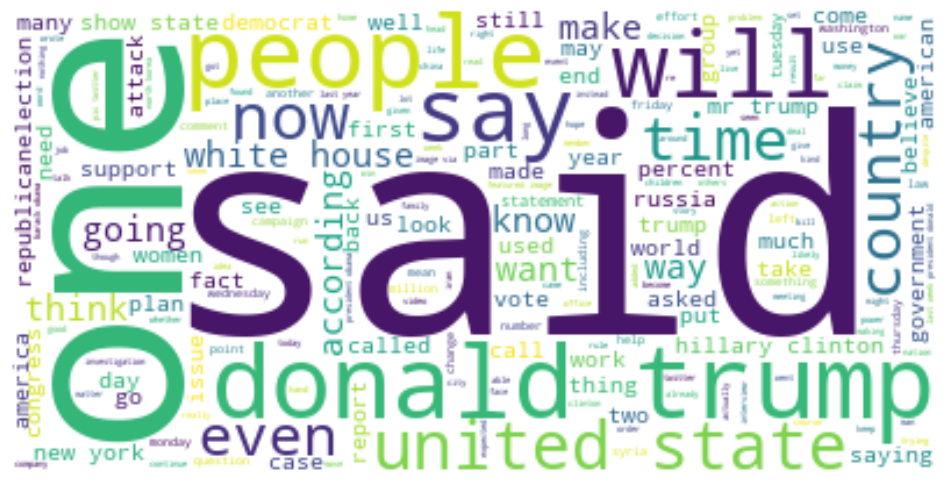

In [13]:
# Generate a wordcloud
text = " ".join(content for content in dataset.text)
wordcloud = WordCloud(background_color="white").generate(text)

# Display it
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We should consider removing stopwords. We can remove these by applying a stopwords filter. There is one supplied by the wordclouds library.

The default filter here does not include "said", but this is a reasonable addition to the stopwords filter for this use case. 
We are not going to analyse who said what or anything, and will be making predictions on this dataset based purely off of word frequencies and/or semantic embeddings. Neither of these will care much about the word "said".

We should also add all the broken contractions to the stopwords.

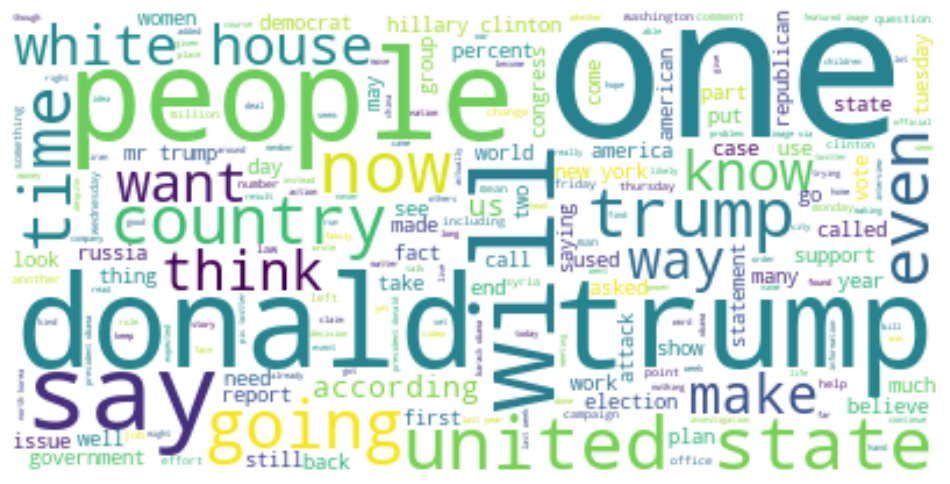

In [14]:
stopwords = set(STOPWORDS)
stopwords.update(['said', 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'])

wordcloud = WordCloud(background_color="white", stopwords=stopwords).generate(text)

# Display our Word Cloud
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Viewing some statistics about the data

6.4
4.8


<Axes: ylabel='count'>

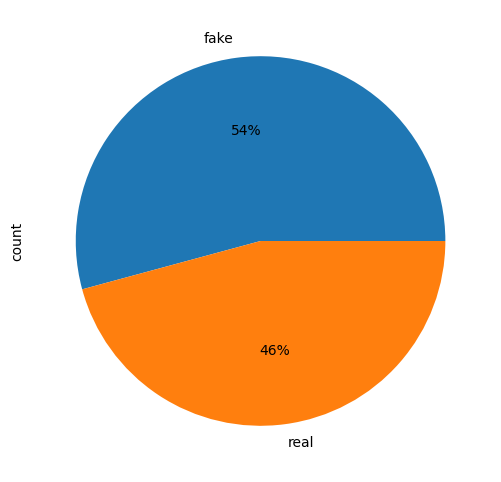

In [15]:
# Plot pie chart showing the split beyween real and fake
plot_size = plt.rcParams["figure.figsize"] 
print(plot_size[0]) 
print(plot_size[1])

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size

dataset.label.value_counts().plot(kind='pie', autopct='%1.0f%%')

Slight weighting towards fake posts. Possibly worth considering a weighted loss function.

Plot top unigrams and bigrams per label:

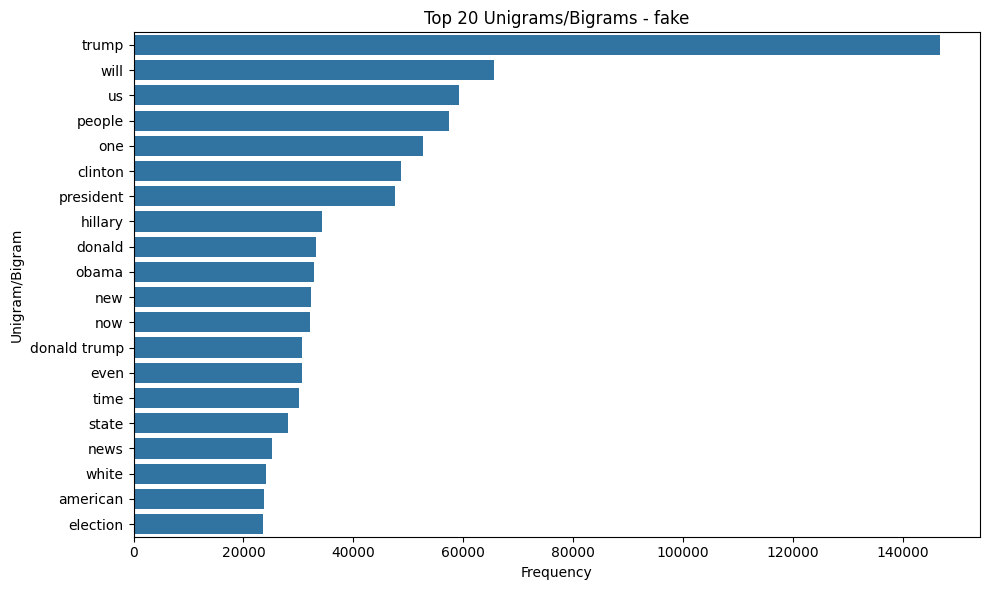

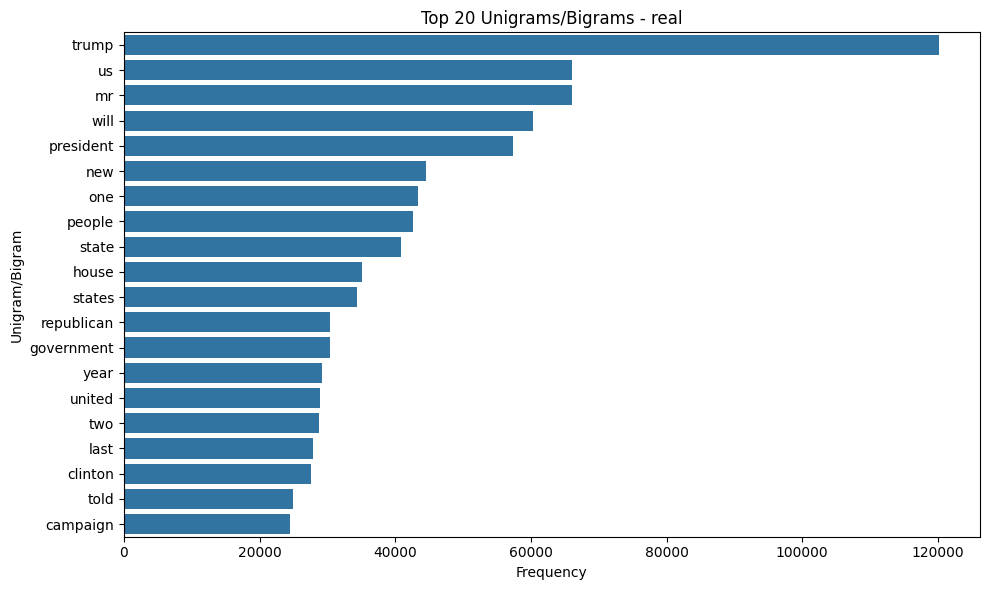

In [21]:
stopwords = set(STOPWORDS)
stopwords.update(['said', 'said', 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'])
stopwords = list(stopwords)

def plot_top_unibigrams(corpus, label_name='All', top_n=20):

    vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words=stopwords, lowercase=True)
    X = vectorizer.fit_transform(corpus)
    gram_counts = X.sum(axis=0).A1
    grams = vectorizer.get_feature_names_out()

    freq_df = pd.DataFrame({'bigram': grams, 'count': gram_counts})
    freq_df = freq_df.sort_values(by='count', ascending=False).head(top_n) # Only plot top n values

    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='bigram', data=freq_df)
    plt.title(f'Top {top_n} Unigrams/Bigrams - {label_name}')
    plt.xlabel('Frequency')
    plt.ylabel('Unigram/Bigram')
    plt.tight_layout()
    plt.show()
    
for label in dataset['label'].unique():
    subset = dataset[dataset['label'] == label]
    plot_top_unibigrams(subset['text'], label_name=label)

Plot just bigrams:

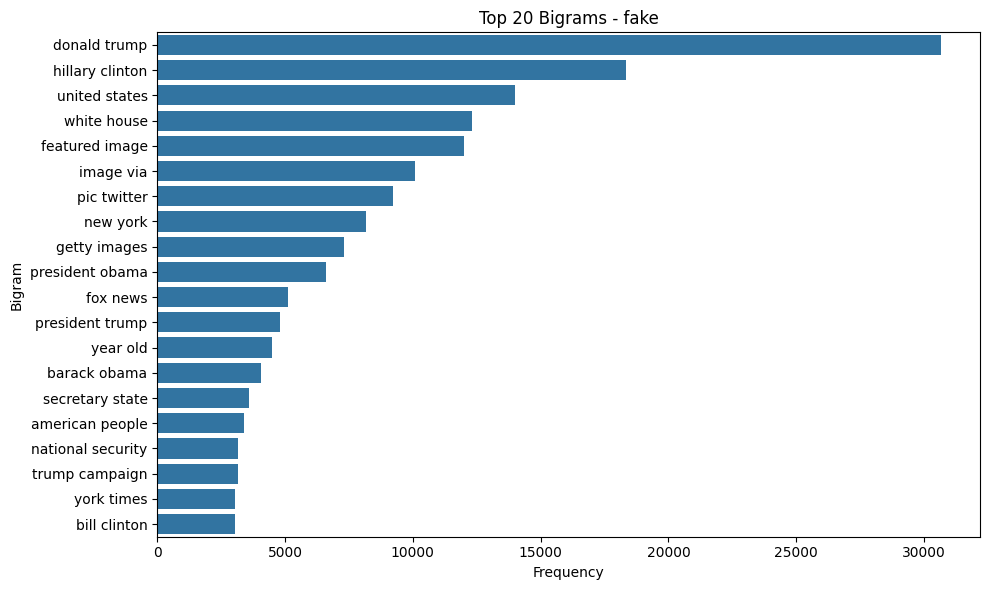

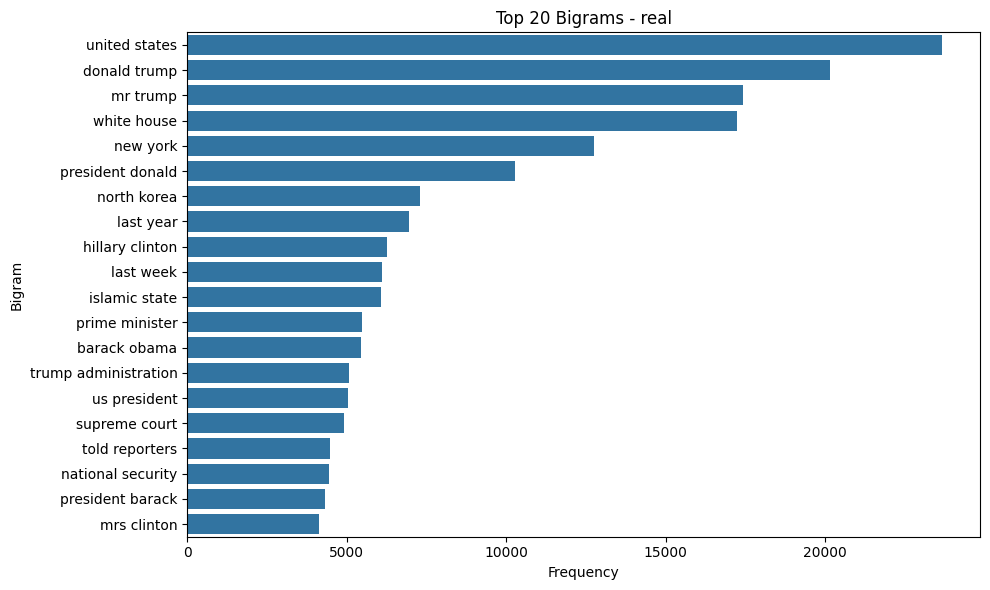

In [22]:
stopwords = set(STOPWORDS)
stopwords.update(['said', 'said', 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'])
stopwords = list(stopwords)

def plot_top_bigrams(corpus, label_name='All', top_n=20):

    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words=stopwords, lowercase=True)
    X = vectorizer.fit_transform(corpus)
    gram_counts = X.sum(axis=0).A1
    grams = vectorizer.get_feature_names_out()

    freq_df = pd.DataFrame({'bigram': grams, 'count': gram_counts})
    freq_df = freq_df.sort_values(by='count', ascending=False).head(top_n) # Only plot top n values

    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='bigram', data=freq_df)
    plt.title(f'Top {top_n} Bigrams - {label_name}')
    plt.xlabel('Frequency')
    plt.ylabel('Bigram')
    plt.tight_layout()
    plt.show()
    
for label in dataset['label'].unique():
    subset = dataset[dataset['label'] == label]
    plot_top_bigrams(subset['text'], label_name=label)

There are some super common words that are common between both classes, so let's try using TF-IDF instead.

Plotting top unigrams/bigrams with TF-IDF:

Total grams: 321378


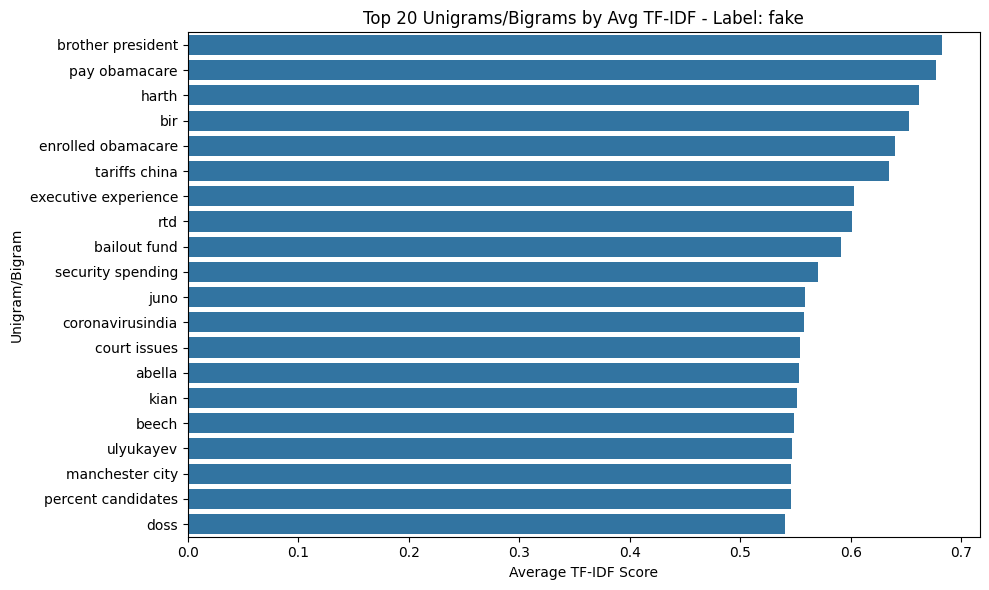

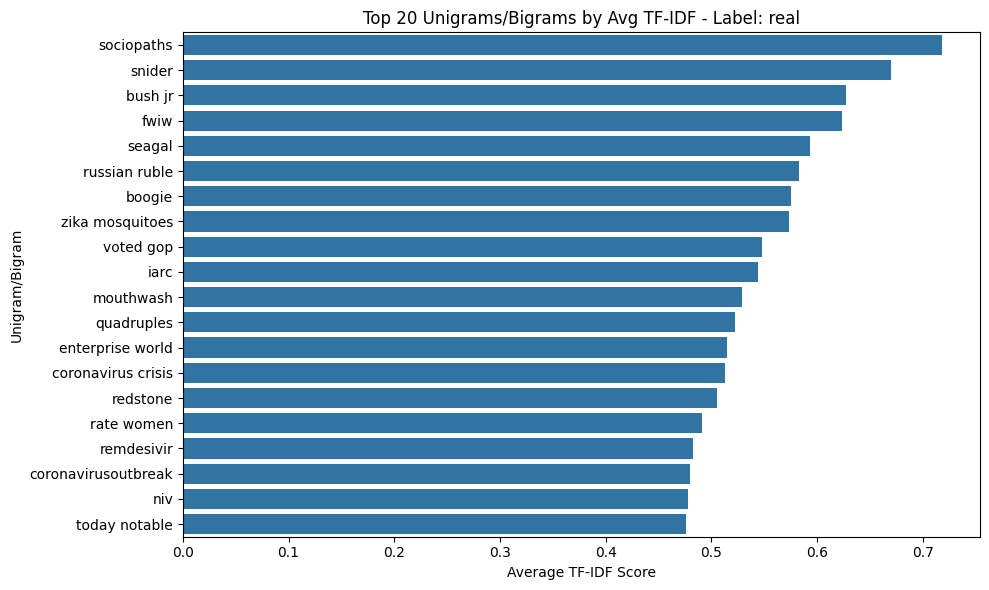

In [ ]:
stopwords = set(STOPWORDS)
stopwords.update(['said', 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'])
stopwords = list(stopwords)

# We have to do vectorisation with the entire dataset because of how TF-IDF works
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words=stopwords, min_df=10) # (1, 2) for unigrams and bigrams. Limit to only grams that appear in at least 10 documents.
tfidf_matrix = vectorizer.fit_transform(dataset['text'])
feature_names = vectorizer.get_feature_names_out()
print(f"Total grams: {len(feature_names)}")

labels = dataset['label'].unique()

for label in labels:
    subset_idx = dataset[dataset['label'] == label].index
    subset_matrix = tfidf_matrix[subset_idx]
    terms = vectorizer.get_feature_names_out()

    tfidf_coo = coo_matrix(subset_matrix)

    term_indices = tfidf_coo.col
    tfidf_values = tfidf_coo.data

    df_tfidf = pd.DataFrame({'term': terms[term_indices],'tfidf': tfidf_values})

    # Group by term and calculate mean
    avg_tfidf_df = df_tfidf.groupby('term')['tfidf'].mean().reset_index()
    avg_tfidf_df = avg_tfidf_df.sort_values(by='tfidf', ascending=False)

    top_20_tfidf = avg_tfidf_df.head(20)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='tfidf', y='term', data=top_20_tfidf)
    plt.title(f'Top 20 Unigrams/Bigrams by Avg TF-IDF - Label: {label}')
    plt.xlabel('Average TF-IDF Score')
    plt.ylabel('Unigram/Bigram')
    plt.tight_layout()
    plt.show()

While this doesn't really reveal any additional processing we should do, there clearly are some patterns in vocabulary usage that can differentiate real and fake news.

Several of these also do make some sort of logical sense as well.

There are certainly some outliers here which just happen to be in a single document an absurd amount of times, but for the most part these terms are reasonably used.

Trying some basic semantic analysis with Word2Vec.

We will display this as a colour-coded UMAP.

c:\Users\user\.conda\envs\CTIP\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


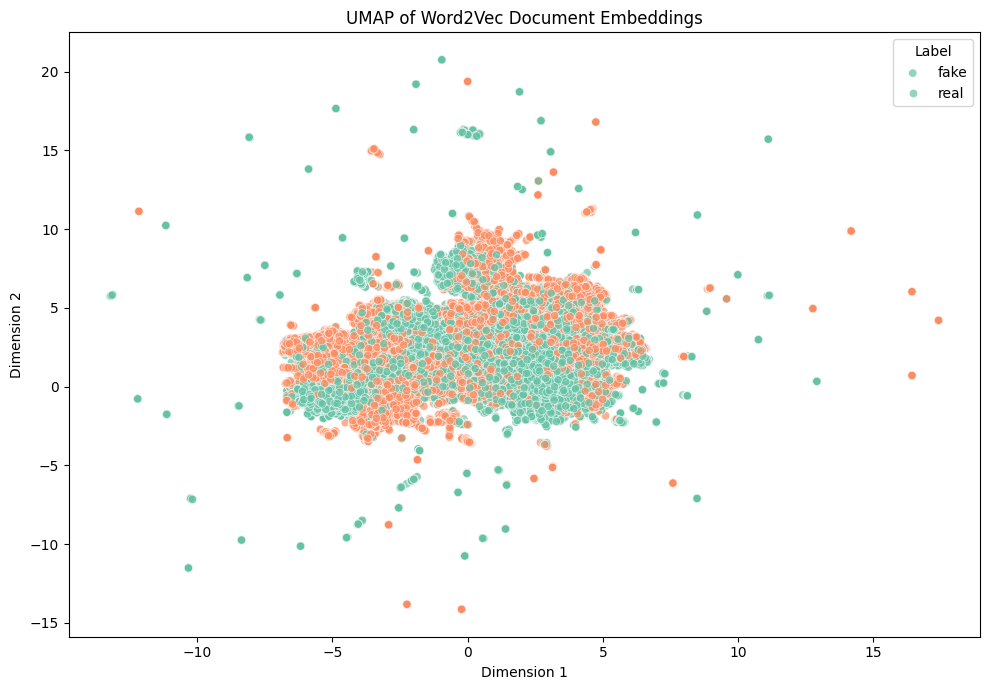

In [ ]:
# Use gensim's simple tokeniser
dataset['tokens'] = dataset['text'].apply(lambda x: simple_preprocess(x))

model = Word2Vec(
    sentences=dataset['tokens'],
    vector_size=64,
    window=5,
    min_count=5, # At least 5 instances of the word
    workers=4,
    sg=1  # Using skip gram because I suspect it will work better than CBOW here.
)

def average_word_vector(tokens, model, vector_size):
    valid_tokens = [t for t in tokens if t in model.wv]
    if not valid_tokens:
        return np.zeros(vector_size)
    return np.mean([model.wv[t] for t in valid_tokens], axis=0)

vector_size = model.vector_size
doc_vectors = np.vstack([average_word_vector(tokens, model, vector_size) for tokens in dataset['tokens']])

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
doc_2d = reducer.fit_transform(doc_vectors)

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(dataset['label'])

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=doc_2d[:, 0], y=doc_2d[:, 1],
    hue=labels,
    palette='Set2',
    alpha=0.7,
    legend="full"
)
plt.title("UMAP of Word2Vec Document Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.tight_layout()
plt.show()